<a href="https://colab.research.google.com/github/DeepkMenon/Mask_RCNN_for_Final_Results/blob/main/Detectron2_MaskRCNN_From_Mike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-05_9j7zw
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-05_9j7zw
     |████████████████████████████████| 596 kB 37.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65176 sha256=916b1636beafb86793ce6c28852889fa2b8038a75fec692b2eea16353fd2aee1
  Stored in directory: /tmp/pip-ephem-wheel-cache-axostpv4/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.11.0+cu113'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo



Cloning into 'detectron2_repo'...
remote: Enumerating objects: 14172, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 14172 (delta 19), reused 52 (delta 14), pack-reused 14099
Receiving objects: 100% (14172/14172), 5.86 MiB | 27.02 MiB/s, done.
Resolving deltas: 100% (10227/10227), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 79 kB 7.5 MB/s 
     |████████████████████████████████| 151 kB 69.7 MB/s 
     |████████████████████████████████| 1.4 MB 58.4 MB/s 
     |████████████████████████████████| 96 kB 3.5 MB/s 
     |████████████████████████████████| 843 kB 57.6 MB/s 
     |████████████████████████████████| 117 kB 59.4 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=558d5bbeed726d5ab64b3a9ad1e40507b94f3bd1c


# Install detectron2

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use the pest dataset that has been annotated
which has 15  classes: 


*  
blister beetle



*   ash weevil
*   blister beetle
*   fruit fly
*   fruit sucking moth
*   helicoverpa
*   hellula undalis
*   plutella xylostella larva
*   leaf webber
*   leucinodes
*   mealy bug
*   pieris brassicae caterpillar
*   root grubs
*   schizaphis gramium
*   uroleucon compositae
*   whitefly

We'll train the pest segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.The COCO dataset does not have any of these three categories. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [2]:
!curl -L "https://app.roboflow.com/ds/5NLpS253PT?key=XJsbM1kpeX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Streaming output truncated to the last 5000 lines.
 extracting: train/Uroleucon_compositae_81_png_jpg.rf.fbd6f374aa71576b04f91417c4bdbaf1.jpg  
 extracting: train/Uroleucon_compositae_85_png_jpg.rf.209101865d7fade5d623c55a183f47b2.jpg  
 extracting: train/Uroleucon_compositae_85_png_jpg.rf.30cf9ef406886ad0214f5640e8da55dc.jpg  
 extracting: train/Uroleucon_compositae_85_png_jpg.rf.3ce90a1252b1c80033c335036f1ca69f.jpg  
 extracting: train/Uroleucon_compositae_87_png_jpg.rf.625d56cf1e60263e2b40bcd1808402f7.jpg  
 extracting: train/Uroleucon_compositae_87_png_jpg.rf.6edd68d5c57f6c5086c35298a95cb680.jpg  
 extracting: train/Uroleucon_compositae_87_png_jpg.rf.c237729c027c1aa750ee27122794c2f9.jpg  
 extracting: train/Uroleucon_compositae_88_png_jpg.rf.135ecf5b93406d44ffef28f4f0096f94.jpg  
 extracting: train/Uroleucon_compositae_88_png_jpg.rf.7c81b486513e038dc7ba19912a9ffc0d.jpg  
 extracting: train/Uroleucon_compositae_88_png_jpg.rf.9e47731032cfb6de190306eb8cf6ad4b.jpg  
 extracting: train/

In [3]:
#!curl -L "https://app.roboflow.com/ds/w2UVmjc51G?key=e4CVHXwtDc" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [4]:
# !wget https://github.com/DeepkMenon/Mask-RCNN-PestTest/raw/main/dataset.zip
# !unzip /content/dataset.zip

Register the above dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. User should write such a function when using a dataset in custom format. See the tutorial for more details.

In [5]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pest_train", {}, "/content/train/_annotations.coco.json", "/content/train")

In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pest_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")

In [8]:
pest_train_metadata = MetadataCatalog.get("pest_train")
dataset_dicts = DatasetCatalog.get("pest_train")

WARNING [05/31 08:55:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 08:55:50 d2.data.datasets.coco]: Loaded 6076 images in COCO format from /content/train/_annotations.coco.json


In [9]:
pest_train_metadata

Metadata(evaluator_type='coco', image_root='/content/train', json_file='/content/train/_annotations.coco.json', name='pest_train', thing_classes=['Pests', 'Hellula undalis', 'Leaf Webber', 'ash weevil', 'blister beetle', 'fruit fly', 'fruit sucking moth', 'helicoverpa', 'leucinodes', 'mealy bug', 'pieris', 'plutella', 'root grubs', 'schizaphis graminum', 'uroleucon compositae', 'whitefly'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15})

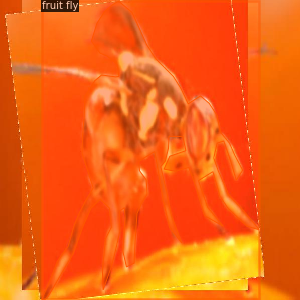

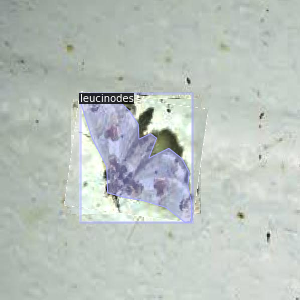

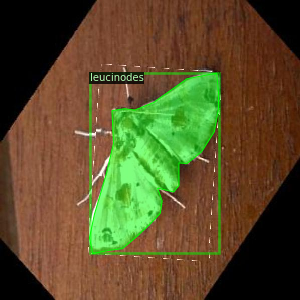

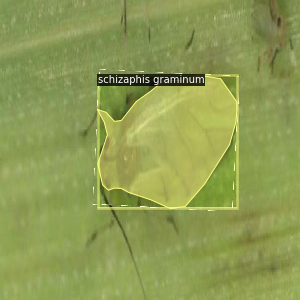

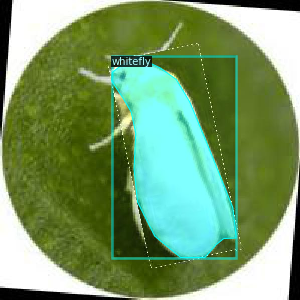

In [10]:
import random

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pest_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [11]:
#https://app.roboflow.com/ds/5NLpS253PT?key=XJsbM1kpeX  --> Roboflow id for Pest Vision NEWW ,2nd Generaated 

In [12]:
#https://app.roboflow.com/ds/5NLpS253PT?key=XJsbM1kpeX -->Roboflow id for Pest Vision NEWW ,3rd Generaated

## Train!

Now, let's fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~2 minutes to train 300 iterations on a P100 GPU.

In [13]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os



cfg = get_cfg()
cfg.merge_from_file(
    "./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
num_gpu = 1
bs = (num_gpu * 2)
cfg.SOLVER.BASE_LR = 0.02 * bs / 16  # pick a good LR
cfg.DATASETS.TRAIN = ("pest_train",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
#cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (
    30000
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 16 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/31 08:56:38 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:04, 39.5MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (17, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (17,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (64, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (64,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due 

[05/31 08:56:49 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/31 08:56:57 d2.utils.events]:  eta: 2:54:06  iter: 19  total_loss: 4.074  loss_cls: 2.74  loss_box_reg: 0.6563  loss_mask: 0.6932  loss_rpn_cls: 0.007104  loss_rpn_loc: 0.00667  time: 0.3383  data_time: 0.0158  lr: 4.9952e-05  max_mem: 1858M
[05/31 08:57:04 d2.utils.events]:  eta: 2:54:08  iter: 39  total_loss: 2.53  loss_cls: 1.31  loss_box_reg: 0.558  loss_mask: 0.6889  loss_rpn_cls: 0.003026  loss_rpn_loc: 0.008259  time: 0.3473  data_time: 0.0109  lr: 9.9902e-05  max_mem: 1858M
[05/31 08:57:11 d2.utils.events]:  eta: 2:55:39  iter: 59  total_loss: 2.078  loss_cls: 0.727  loss_box_reg: 0.6037  loss_mask: 0.6778  loss_rpn_cls: 0.005293  loss_rpn_loc: 0.006239  time: 0.3532  data_time: 0.0114  lr: 0.00014985  max_mem: 1858M
[05/31 08:57:18 d2.utils.events]:  eta: 2:55:32  iter: 79  total_loss: 1.807  loss_cls: 0.5549  loss_box_reg: 0.5753  loss_mask: 0.6698  loss_rpn_cls: 0.002553  loss_rpn_loc: 0.006243  time: 0.3507  data_time: 0.0112  lr: 0.0001998  max_mem: 1858M
[05/31 08:57:

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:

In [17]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[05/31 12:06:55 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

In [18]:
pest_val_metadata = MetadataCatalog.get("pest_val")
dataset_dicts = DatasetCatalog.get("pest_val")

WARNING [05/31 12:06:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 12:06:58 d2.data.datasets.coco]: Loaded 844 images in COCO format from /content/valid/_annotations.coco.json


In [19]:
pest_val_metadata

Metadata(evaluator_type='coco', image_root='/content/valid', json_file='/content/valid/_annotations.coco.json', name='pest_val', thing_classes=['Pests', 'Hellula undalis', 'Leaf Webber', 'ash weevil', 'blister beetle', 'fruit fly', 'fruit sucking moth', 'helicoverpa', 'leucinodes', 'mealy bug', 'pieris', 'plutella', 'root grubs', 'schizaphis graminum', 'uroleucon compositae', 'whitefly'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15})

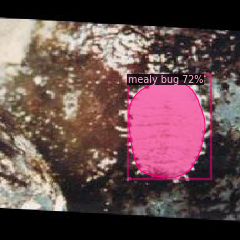

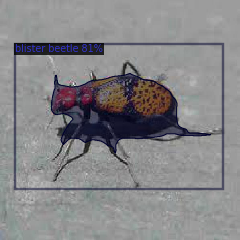

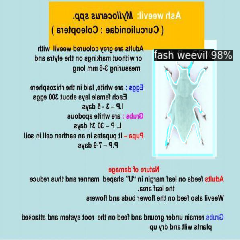

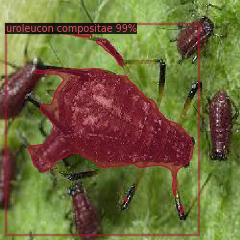

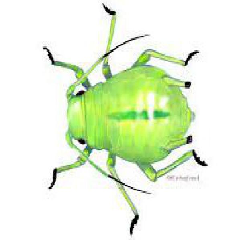

In [29]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=pest_val_metadata, 
                   scale=0.4, 
                   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

#instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels    

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.09,fps:10.67


We can also evaluate its performance using AP metric implemented in COCO API.


In [28]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("pest_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "pest_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [05/31 12:11:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 12:11:03 d2.data.datasets.coco]: Loaded 844 images in COCO format from /content/valid/_annotations.coco.json
[05/31 12:11:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/31 12:11:03 d2.data.common]: Serializing 844 elements to byte tensors and concatenating them all ...
[05/31 12:11:03 d2.data.common]: Serialized dataset takes 0.95 MiB
[05/31 12:11:03 d2.evaluation.evaluator]: Start inference on 844 batches
[05/31 12:11:04 d2.evaluation.evaluator]: Inference done 11/844. Dataloading: 0.0012 s/iter. Inference: 0.0778 s/iter. Eval: 0.0006 s/iter. Total: 0.0796 s/iter. ETA=0:01:06
[05/31 12:11:09 d2.evaluation.evaluator]: Inference done 73/844. Dataloading: 0.0019 s/iter. Inference: 0.0785 s/iter. Eval: 0.0009 s/iter. Total: 0

## Visualization and curve drawing of detectron2 various losses 

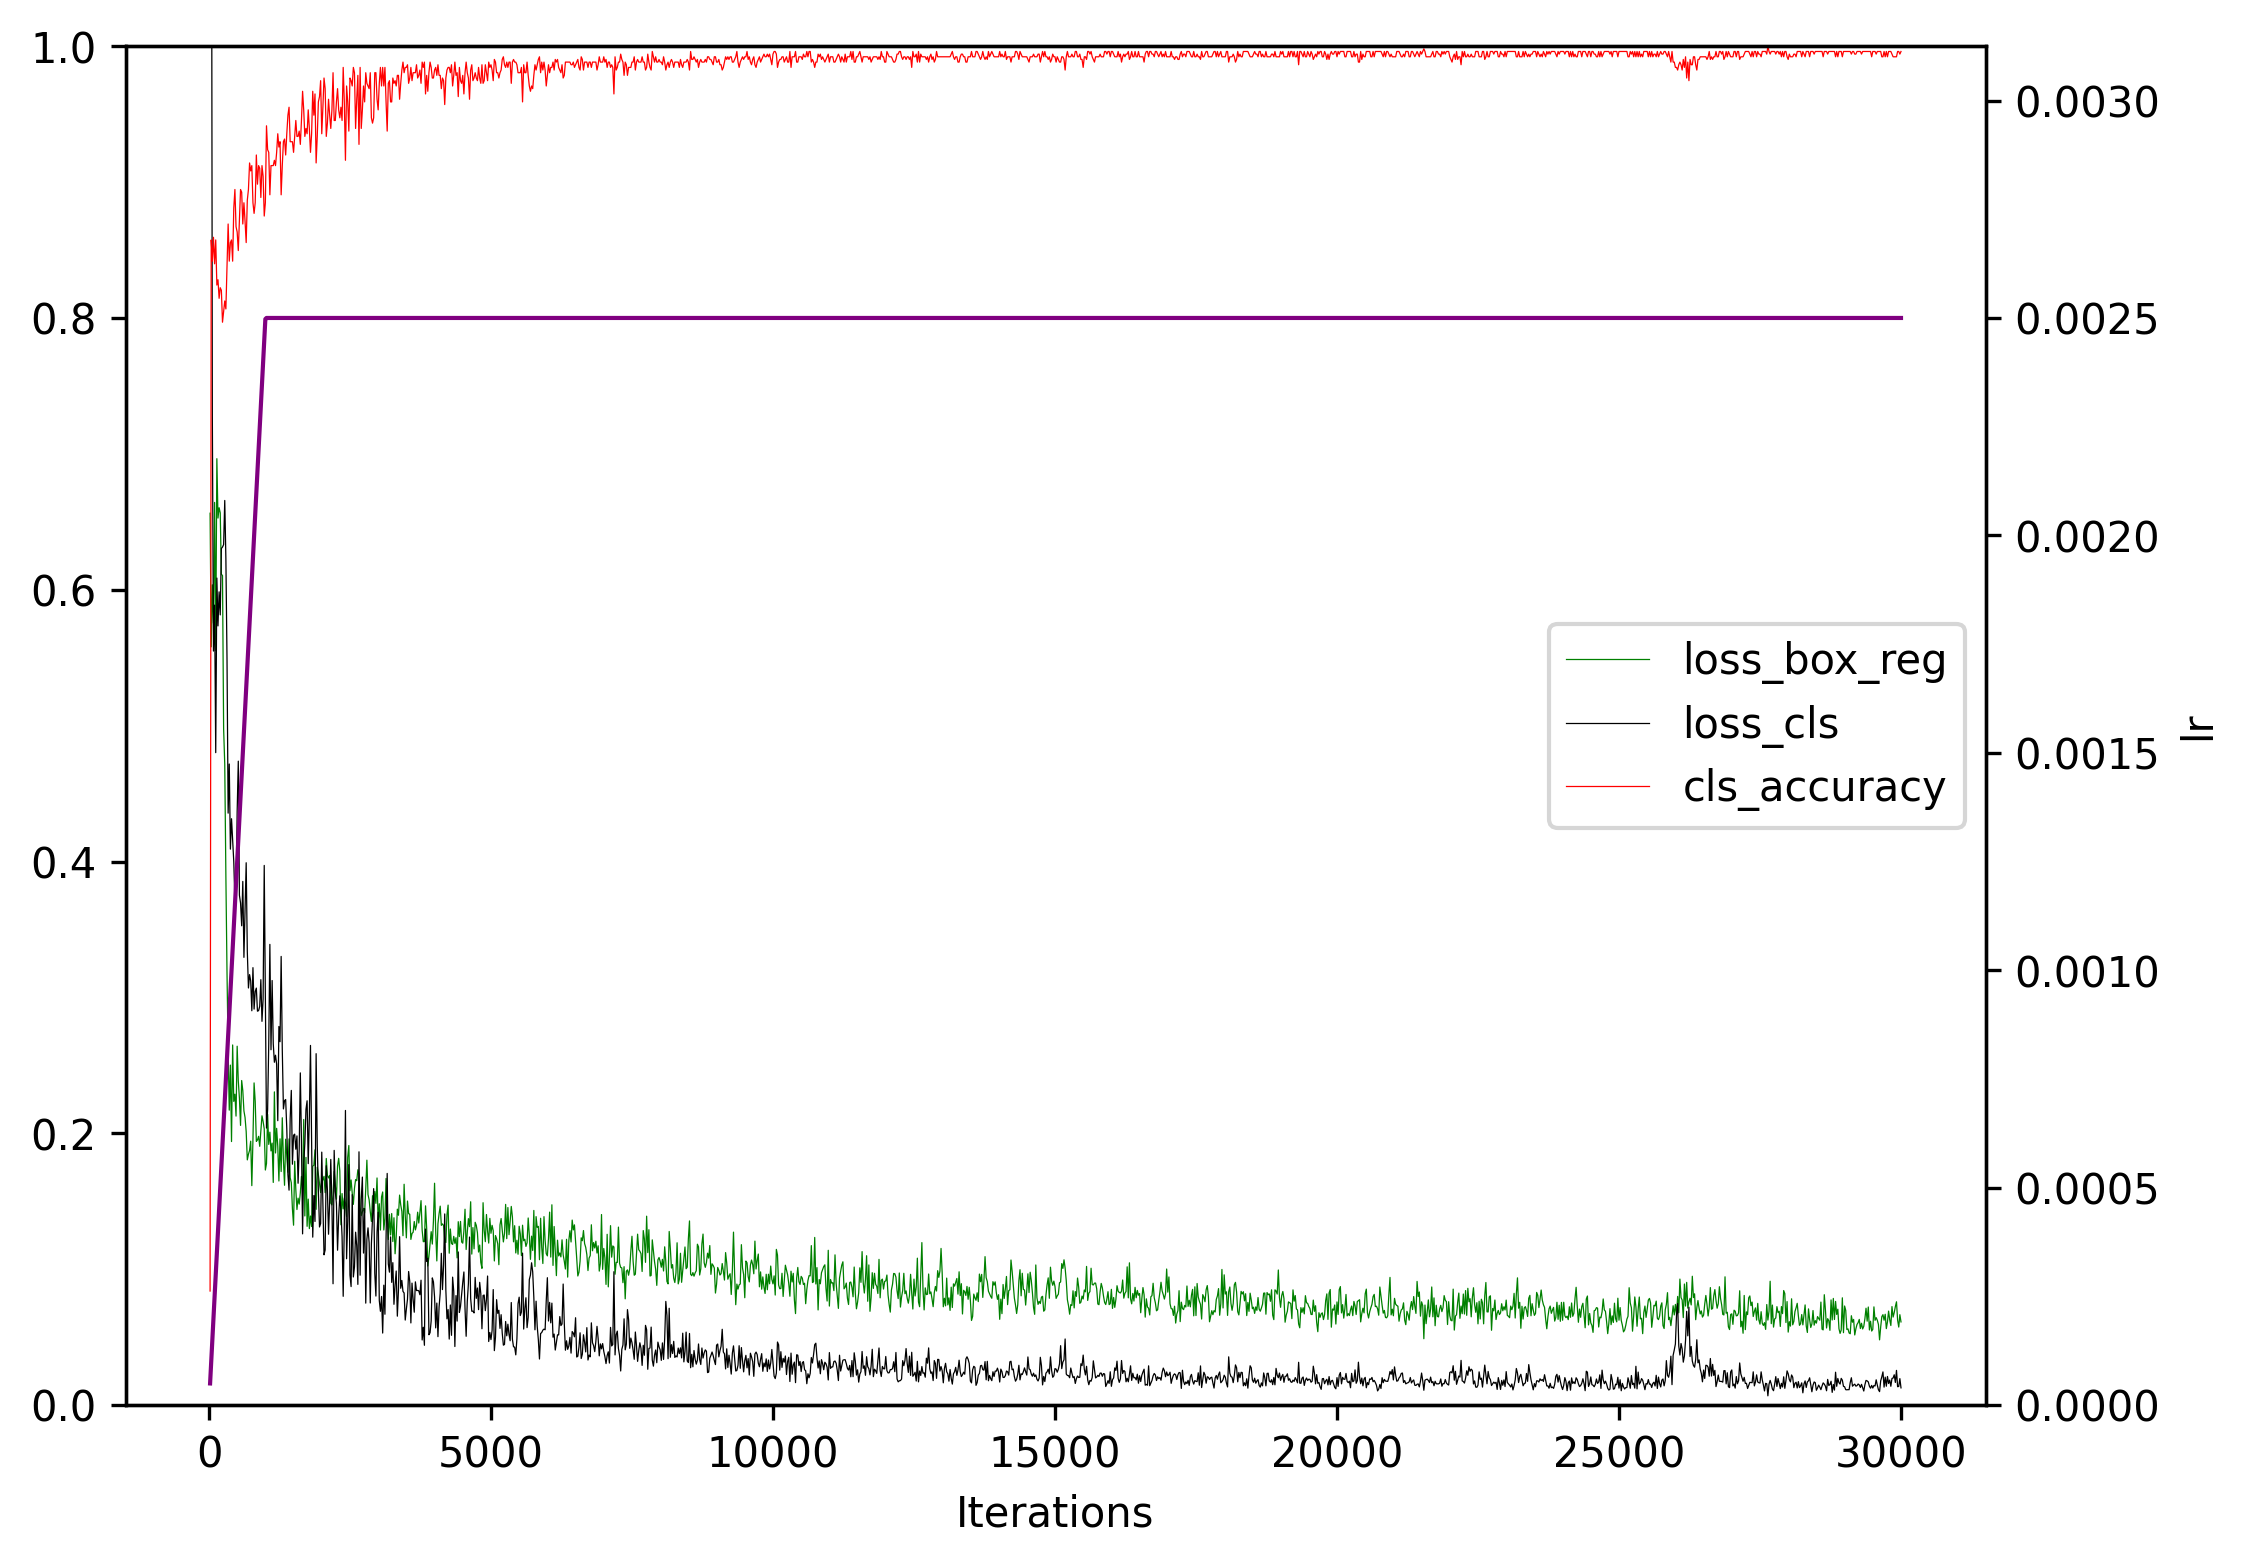

In [24]:
import json
import re
from pylab import *
fig = figure(figsize=(8,6), dpi=300)
y1 = fig.add_subplot(111)
y1.set_xlabel('Iterations')
y2 = y1.twinx()
y1.set_ylim(0,1.0)
parsed=[]
with open('/content/output/metrics.json') as f:
    # whole = f.read()
    # # #pattern = re.compile(r'json_stats: (\{.*\})')
    # pattern = re.compile(r'\"data_time\":.*')
    # # #r:ban zhaunyi
    # lis = pattern.findall(whole)
    try:
        #ke neng chu xian de yi chang kuai
        # parsed = [json.loads(j) for j in lis]
        for line in f:
            parsed.append(json.loads(line))
        # print(parsed[0])

    except:
        #shang shu yi chang kuai de chu li fang fa
        print("json format is not corrrect")
        exit(1)

    _iter = [j['iteration'] for j in parsed]
    #_loss = [j['total_loss'] for j in parsed]
    _loss_bbox = [j['loss_box_reg'] for j in parsed]
    _loss_cls = [j['loss_cls'] for j in parsed]
    try:
         _accuracy_cls = [j['fast_rcnn/cls_accuracy'] for j in parsed]
    except:
        _accuracy_cls = None
    _lr = [j['lr'] for j in parsed]
    try:
        _mask_loss = [j['mask_loss'] for j in parsed]
    except:
        _mask_loss = None

    y1.plot(_iter, _loss_bbox, color="green", linewidth=0.3,linestyle="-",label='loss_box_reg')

    #y1.plot(_iter, _loss, color="blue", linewidth=0.3, linestyle="-",label='total_loss')
    y1.plot(_iter, _loss_cls, color="black", linewidth=0.3, linestyle="-",label='loss_cls')
    y1.plot(_iter, _accuracy_cls, color="red", linewidth=0.3, linestyle="-",label='cls_accuracy')
    if _mask_loss is not None:
         y1.plot(_iter, _mask_loss, color="grey", linewidth=0.3, linestyle="-",label='mask_loss')

    y2.set_ylim(0,max(_lr)/0.8)
    y2.plot(_iter, _lr, color="purple", linewidth=1.0, linestyle="-",label='lr')
    y2.set_ylabel('lr')

    #可以选择开启网格
    #grid()
    #图例
    y1.legend()
    savefig('./fig.png')
    show()

## Saving the model and metrics

In [14]:
import shutil


In [15]:
shutil.copy("/content/output/model_final.pth","/content/drive/MyDrive/Models")

'/content/drive/MyDrive/Models/model_final.pth'

In [16]:
shutil.copy("/content/output/metrics.json","/content/drive/MyDrive/Metrics")

'/content/drive/MyDrive/Metrics/metrics.json'

## Testing


`Before testing we need to register our test dataset into coco dataset format. We can do that even without requiring annotations`.

In [30]:
# Detectron2 requires a annotation file in COCO format even for validation and testing.
# So we use the below fn to create a COCO fomat annotation file for our testing images.  
from fastai.imports import *
from PIL import Image

def add_images_to_coco(image_dir, coco_filename):
  image_filenames = list(Path(image_dir).glob('*.jpg'))
  images = []
  id=0
  for i, image_filename in enumerate(image_filenames):
    im = Image.open(image_filename)
    width, height = im.size
    
    image_details = {
     "id": id + 1,
     "height": height,
     "width": width,
     "file_name": str(image_filename.resolve()),
     }
    id=id+1
    images.append(image_details)

  #Opening the .json sample file
  a_file = open('/content/coco.json', "r")
  json_object = json.load(a_file)
  a_file.close()
  #print(json_object)

  #Adding the image details to the .json file
  json_object["images"] = images

  #Closing the openend file object
  a_file = open("/content/coco.json", "w")
  json.dump(json_object, a_file)
  a_file.close()


Now we will call our `add_images_to_coco` funtion on our test dataset 

In [31]:
add_images_to_coco('/content/test','/content/coco.json')

The real testing begins:

In [32]:
from detectron2.utils.logger import setup_logger
setup_logger()
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [33]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("pest_test_10", {}, "/content/coco.json", "/content/test")

In [34]:
pest_test_metadata1 = MetadataCatalog.get("pest_test_10")
dataset_dicts = DatasetCatalog.get("pest_test_10")

WARNING [05/31 12:35:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/31 12:35:06 d2.data.datasets.coco]: Loaded 3 images in COCO format from /content/coco.json


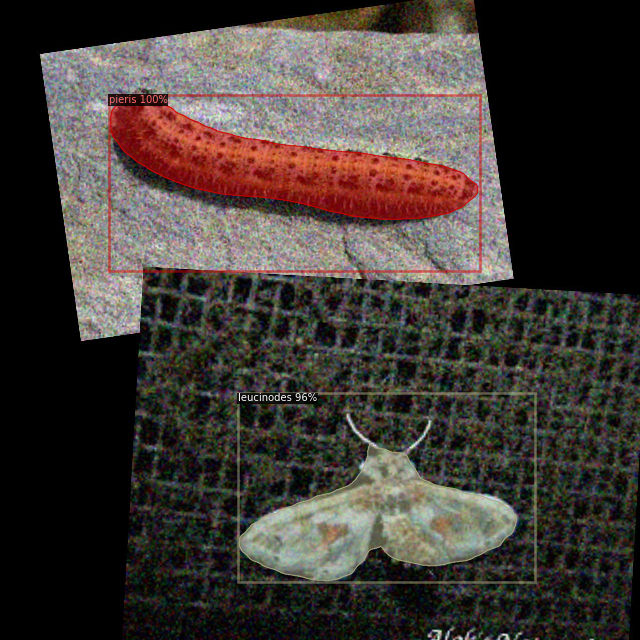

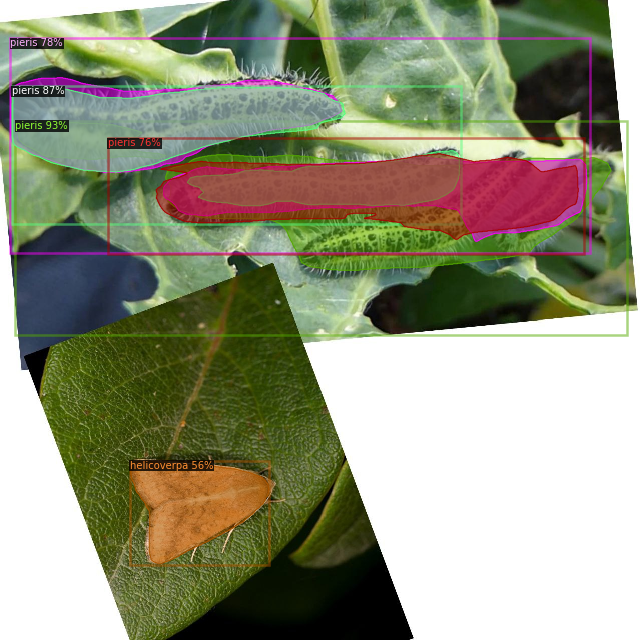

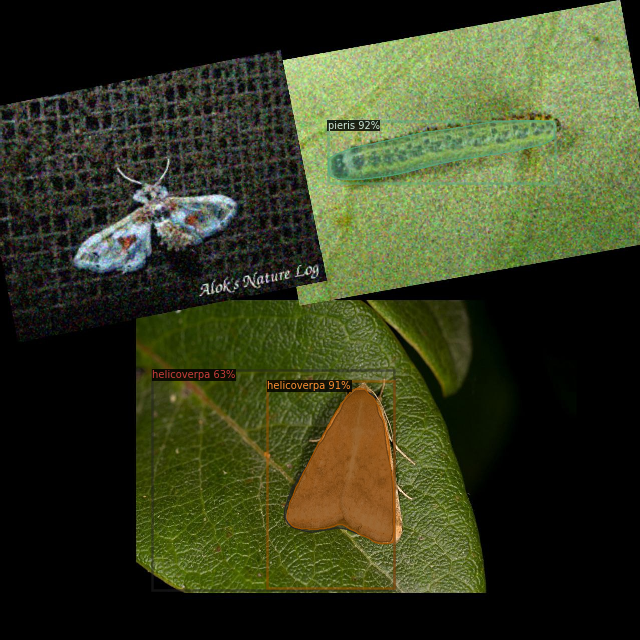

In [35]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=pest_test_metadata1, 
                   scale=0.5, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
# import shutil

# shutil.rmtree('/content/pest/test')

## Other code for training

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pest_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02  # pick a good LR
cfg.SOLVER.MAX_ITER = 4000   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 15  # has three classes. (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()